# Predicting Viral Host from Codon Usage Bias

### Kathleen Hablutzel
### BIO 334/335 Bioinformatics Final Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# all my helper functions
from helper import *

In [2]:
# load data
bias_pd = pd.read_csv("datasets/report/cub_full_genome.csv")
bias_pd.shape

(9701, 69)

In [3]:
bias_pd.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,AGG,GGU,GGC,GGA,GGG,AccessionNum,SeqLen,Nc,Species,Taxon
0,0.457776,0.542224,0.073146,0.136493,0.138130,0.190055,0.078648,0.383528,0.354512,0.476869,...,0.219182,0.180696,0.317858,0.265441,0.236004,GCF_903992535.2_mArvAmp1.2,77272509,54.457136,Arvicola_amphibius,vertebrate_mammalian
1,0.474425,0.525575,0.085792,0.133677,0.136818,0.189876,0.069925,0.383912,0.363281,0.459382,...,0.219056,0.164273,0.325674,0.258978,0.251075,GCF_000493695.1_BalAcu1.0,69532407,54.651624,Balaenoptera_acutorostrata,vertebrate_mammalian
2,0.475298,0.524702,0.088171,0.135714,0.139210,0.191816,0.068511,0.376578,0.366103,0.452923,...,0.218796,0.168386,0.318368,0.265256,0.247990,GCF_000754665.1_Bison_UMD1.0,62252778,54.839233,Bison_bison,vertebrate_mammalian
3,0.453638,0.546362,0.078937,0.127617,0.129814,0.198149,0.064855,0.400627,0.351219,0.479417,...,0.211618,0.159878,0.338769,0.247034,0.254319,GCF_000247795.1_Bos_indicus_1.0,64918074,53.953278,Bos_indicus,vertebrate_mammalian
4,0.449071,0.550929,0.077686,0.128257,0.129594,0.197832,0.066708,0.399924,0.351122,0.482238,...,0.205152,0.157745,0.345172,0.241409,0.255674,GCF_002288905.1_ASM228890v2,67099479,53.983387,Enhydra_lutris,vertebrate_mammalian


In [4]:
# store which columns we drop to just get 59 codons
drop_columns = ["AUG", "UGA", "UAA", "UAG", "UGG", "AccessionNum", "SeqLen", "Nc", "Species", "Taxon"]
# drop_columns_biased = drop_columns + ["BiasedSeqLen", "PropBiasedRegions", "BiasedNc"]

### Visualizations

In [5]:
# summarize entire dataset in 2d
bias_2d = reduce_dim(bias_pd, dim=2, drop_columns=drop_columns, vertebrate=False)
bias_2d.shape
bias_2d.head()

,Dim1,Dim2,AUG,UGA,UAA,UAG,UGG,AccessionNum,SeqLen,Nc,Species,Taxon
0,0.335693,-0.068775,1.0,0.498901,0.269464,0.231635,1.0,GCF_903992535.2_mArvAmp1.2,77272509,54.457136,Arvicola_amphibius,vertebrate_mammalian
1,0.342254,-0.079371,1.0,0.500936,0.272810,0.226254,1.0,GCF_000493695.1_BalAcu1.0,69532407,54.651624,Balaenoptera_acutorostrata,vertebrate_mammalian
2,0.307215,-0.080829,1.0,0.494974,0.280713,0.224312,1.0,GCF_000754665.1_Bison_UMD1.0,62252778,54.839233,Bison_bison,vertebrate_mammalian
3,0.436720,-0.076458,1.0,0.501819,0.267367,0.230814,1.0,GCF_000247795.1_Bos_indicus_1.0,64918074,53.953278,Bos_indicus,vertebrate_mammalian
4,0.461088,-0.062136,1.0,0.509291,0.262621,0.228088,1.0,GCF_002288905.1_ASM228890v2,67099479,53.983387,Enhydra_lutris,vertebrate_mammalian


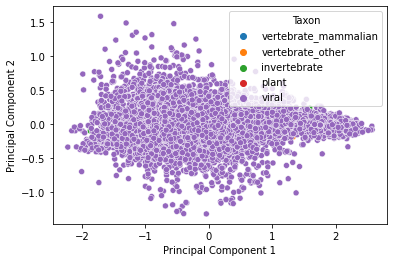

In [6]:
# plot of all CUB in the dataset - overwhelmed by the number of viruses vs. other organisms
sns.scatterplot(data=bias_2d, x='Dim1', y='Dim2', hue='Taxon')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

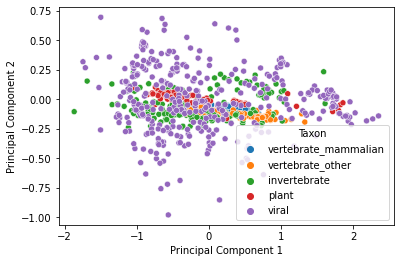

In [7]:
# plot with fewer viruses - still hard to see any meaningful differences
sns.scatterplot(data=bias_2d.head(1000), x='Dim1', y='Dim2', hue='Taxon')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

## Identifying virus host from CUB
Pull in extra viral host data from: https://www.ncbi.nlm.nih.gov/genomes/GenomesGroup.cgi?taxid=10239&cmd=download2
(On https://www.ncbi.nlm.nih.gov/genome/viruses/, it's the Accession List of all viral genomes)

In [8]:
# read in viral data
hosts = pd.read_csv("datasets/viral_hosts.csv", skiprows=[0])
hosts = hosts.drop(columns=["Neighbor", "Segment name", "Representative", "Selected lineage"])

# remove duplicate entries for each virus
hosts = hosts.drop_duplicates(ignore_index=True).dropna()
print(hosts.shape)
hosts.head(10)

(16095, 2)


,Host,Taxonomy name
0,"human,vertebrates",Cowpox virus
1,"human,vertebrates",Monkeypox virus
2,"human,vertebrates",Monkeypox virus Zaire-96-I-16
3,"human,vertebrates",Vaccinia virus
4,"human,vertebrates",Vaccinia virus Copenhagen
5,"human,vertebrates",Vaccinia virus Ankara
6,"human,vertebrates",Vaccinia virus Tian Tan
7,"human,vertebrates",Rabbitpox virus
8,"human,vertebrates",Horsepox virus
9,"human,vertebrates",Buffalopox virus


In [9]:
# follow CUB dataset naming convention
hosts['Species'] = hosts['Taxonomy name'].apply(lambda x: x.replace(" ", "_"))

# column for whether human is host or not
hosts['Human_Host'] = hosts['Host'].apply(lambda x: "human" in x)
hosts.head()

,Host,Taxonomy name,Species,Human_Host
0,"human,vertebrates",Cowpox virus,Cowpox_virus,True
1,"human,vertebrates",Monkeypox virus,Monkeypox_virus,True
2,"human,vertebrates",Monkeypox virus Zaire-96-I-16,Monkeypox_virus_Zaire-96-I-16,True
3,"human,vertebrates",Vaccinia virus,Vaccinia_virus,True
4,"human,vertebrates",Vaccinia virus Copenhagen,Vaccinia_virus_Copenhagen,True


In [10]:
# join in host info where matches any viruses in the CUB dataset
# inner join -> only keep species w/ info in both datasets
virus_cub = pd.merge(bias_pd, hosts, on="Species")
virus_cub.shape

(4660, 72)

In [11]:
# 220 viruses w/ human host
human_sum = np.sum(virus_cub["Human_Host"])
human_sum

220

In [12]:
# keep equal numbers human and non-human viruses
# (otherwise non-human viruses overwhelm the dataset)
np.random.seed(88)
virus_human = virus_cub[virus_cub["Human_Host"]]
virus_non_human = virus_cub[~virus_cub["Human_Host"]]
virus_non_human = shuffle(virus_non_human).head(human_sum)  # keep random viruses - same amt as human viruses

virus_cub_short = pd.concat([virus_human, virus_non_human])
virus_cub_short.shape

(440, 72)

In [13]:
viral_drop_columns = drop_columns + ["Host", "Taxonomy name", "Human_Host"]
virus_cub_short.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,GGA,GGG,AccessionNum,SeqLen,Nc,Species,Taxon,Host,Taxonomy name,Human_Host
49,0.138614,0.861386,0.009050,0.045249,0.167421,0.597285,0.027149,0.153846,0.113043,0.869565,...,0.224359,0.115385,GCF_000861885.1_ViralProj15441,7302,39.524815,Aichivirus_A,viral,"human,vertebrates",Aichivirus A,True
63,0.864198,0.135802,0.255319,0.212766,0.117021,0.037234,0.154255,0.223404,0.489583,0.062500,...,0.241830,0.307190,GCF_000862805.1_ViralProj15451,7050,53.511482,Alphapapillomavirus_3,viral,human,Alphapapillomavirus 3,True
64,0.954545,0.045455,0.502262,0.176471,0.085973,0.018100,0.122172,0.095023,0.482270,0.021277,...,0.348148,0.133333,GCF_000863945.3_ViralProj15505,7446,44.670709,Alphapapillomavirus_9,viral,human,Alphapapillomavirus 9,True
121,0.607143,0.392857,0.191646,0.272727,0.154791,0.095823,0.147420,0.137592,0.419355,0.295699,...,0.260116,0.236994,GCF_000856545.1_ViralMultiSegProj15028,10071,50.229824,Argentinian_mammarenavirus,viral,"human,vertebrates",Argentinian mammarenavirus,True
123,0.440678,0.559322,0.068627,0.238562,0.114379,0.133987,0.163399,0.281046,0.321839,0.390805,...,0.489865,0.222973,GCF_000872985.1_ViralProj18847,10290,54.185837,Aroa_virus,viral,"human,invertebrates,vertebrates",Aroa virus,True


(440, 15)


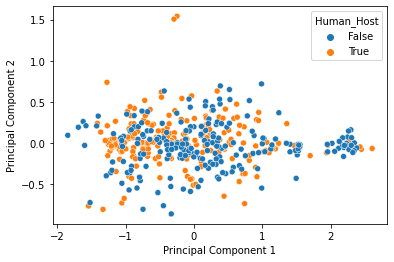

In [14]:
# visualize virus_cub_short
virus_2d = reduce_dim(virus_cub_short, dim=2, drop_columns=viral_drop_columns)
print(virus_2d.shape)
sns.scatterplot(data=virus_2d, x='Dim1', y='Dim2', hue='Human_Host')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

In [15]:
# dataset for our classifier, with just CUB and Human_Host columns

virus_cub_short_num = virus_cub_short.drop(columns=viral_drop_columns[:-1]) # keep Human_Host
virus_cub_short_num.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,CGC,CGA,CGG,AGA,AGG,GGU,GGC,GGA,GGG,Human_Host
49,0.138614,0.861386,0.009050,0.045249,0.167421,0.597285,0.027149,0.153846,0.113043,0.869565,...,0.561905,0.057143,0.171429,0.047619,0.047619,0.250000,0.410256,0.224359,0.115385,True
63,0.864198,0.135802,0.255319,0.212766,0.117021,0.037234,0.154255,0.223404,0.489583,0.062500,...,0.218045,0.090226,0.120301,0.172932,0.187970,0.196078,0.254902,0.241830,0.307190,True
64,0.954545,0.045455,0.502262,0.176471,0.085973,0.018100,0.122172,0.095023,0.482270,0.021277,...,0.109091,0.163636,0.045455,0.363636,0.154545,0.385185,0.133333,0.348148,0.133333,True
121,0.607143,0.392857,0.191646,0.272727,0.154791,0.095823,0.147420,0.137592,0.419355,0.295699,...,0.011364,0.056818,0.022727,0.528409,0.346591,0.312139,0.190751,0.260116,0.236994,True
123,0.440678,0.559322,0.068627,0.238562,0.114379,0.133987,0.163399,0.281046,0.321839,0.390805,...,0.089552,0.079602,0.089552,0.388060,0.303483,0.104730,0.182432,0.489865,0.222973,True


### and now, we build the classifier...

In [22]:
# separate data into test/train and validation sets
np.random.seed(88)
virus_valid, virus_tt = divide_data(virus_cub_short_num)
virus_tt.shape

(396, 60)

In [17]:
# cross-validation for model selection

# get all cv errors for each method
cv_errors = all_cv_errors(virus_tt, ['neighbor', 'tree', 'forest', 'SVM'])

# store best method
best_method = cv_errors[0,0]
lowest_cv_err = cv_errors[0,1]

cv_errors

array([['tree', 0.2626282051282051],
       ['neighbor', 0.29826923076923073],
       ['forest', 0.3106410256410257],
       ['SVM', 0.36903846153846154]], dtype=object)

In [18]:
# print best model
print('best model')
print('method:  ', best_method)
print('error:   ', lowest_cv_err)

best model
method:   tree
error:    0.2626282051282051


In [19]:
# build best type of model
# mod_virus = KNeighborsClassifier(n_neighbors = 9)
# mod_virus = SVC(kernel="sigmoid")
mod_virus = DecisionTreeClassifier()
# mod_virus = RandomForestClassifier(n_estimators=20, max_features=min(3, virus_tt.shape[1] - 1), max_depth=3, random_state=0)
mod_virus.fit(virus_tt.iloc[:,:-1], virus_tt.iloc[:,-1]) # from all but the last column, predict last column

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [20]:
# validate the model
# compute validation error
val_preds = mod_virus.predict(virus_valid.iloc[:,:-1])
val_error = classification_mse(val_preds, virus_valid.iloc[:,-1])
print('validation error:           ', val_error)
print('best cross-validation error:', lowest_cv_err)

validation error:            0.25
best cross-validation error: 0.2626282051282051


In [21]:
# confusion matrix
tp = np.sum((virus_valid.iloc[:,-1]) & (val_preds == 1))  # true positive
tn = np.sum(~(virus_valid.iloc[:,-1]) & (val_preds == 0))  # true negative
fp = np.sum(~(virus_valid.iloc[:,-1]) & (val_preds == 1)) # false positive  # type 1 error
fn = np.sum((virus_valid.iloc[:,-1]) & (val_preds == 0)) # false negative   # type 2 error
print('\tactual class')
print('   p\t\t   n')
print(f'tp: {tp/(tp+fn):.2f}\tfp: {fp/(tn+fp):.2f}')
print(f'fn: {fn/(tp+fn):.2f}\ttn: {tn/(tn+fp):.2f}')

	actual class
   p		   n
tp: 0.78	fp: 0.29
fn: 0.22	tn: 0.71


In our validation set, we correctly predicted whether a virus is hosted by humans or not 75% of the time. Thus, our model performs moderately well, and certainly better than random chance. The moderate success of this classifier  suggests that CUB may be a useful predictor of whether a virus may infect humans, alongside other factors. Potential applications could include incorporating CUB as a factor in models that predict emerging viral threats to the human species.